In [27]:
import torch
import numpy as np
import scipy.io as sio
import os

In [28]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
   device = torch.device("cpu")
   print("Running on the CPU")

Running on the CPU


In [29]:
# Paramètres du modèle
N = 2 # dim de l'input x
m = 100 # dim de l'output y
T = 1 # borne sup pour x
nb_points = 100
nb_maps = 10 # nombre d'images que l'on va générer
nb_blocks = 2 # nombre de blocs dans le modèle

In [30]:
def sample_points(x_dim, method=1, nb_points_omega=2000, nb_points_boundary=400):
    if method == 1:
        assert isinstance(nb_points_boundary//4, int)
        in_omega = torch.rand((nb_points_omega, x_dim))
        points_per_side = nb_points_boundary // 4

        x_left, y_left = torch.zeros((points_per_side, 1)), torch.rand((points_per_side, 1))
        x_right, y_right = torch.ones((points_per_side, 1)), torch.rand((points_per_side, 1))
        x_bottom, y_bottom = torch.rand((points_per_side, 1)), torch.zeros((points_per_side, 1))
        x_top, y_top = torch.rand((points_per_side, 1)), torch.ones((points_per_side, 1))
        
        on_boundary_x, on_boundary_y = torch.cat((x_left, x_right, x_bottom, x_top)), torch.cat((y_left, y_right, y_bottom, y_top))
        on_boundary = torch.cat((on_boundary_x, on_boundary_y), dim=1)

        boundary_mask = torch.zeros((nb_points_omega+nb_points_boundary), dtype=torch.bool)
        boundary_mask[nb_points_omega:] = 1

        return torch.cat((in_omega, on_boundary), dim=0), boundary_mask
    else:
        nb_subdivisions = 10
        assert isinstance(nb_points_omega//nb_subdivisions, int)
        assert isinstance(nb_points_boundary//4, int)
        raise NotImplementedError

def source_term(x, lhs_coeff, dim=2):
    if dim == 2 :
        x1, x2 = x[:, 0], x[:, 1]
        alpha, beta, gamma = lhs_coeff[0]
        source_term = alpha * np.pi**2 * (x1**2 + x2**2) * np.sin(np.pi*(x1 + beta)*(x2 + gamma))
        return source_term
    else :
        raise NotImplementedError

def MC_boundary(nb_points, range_x, range_y):
    assert isinstance(nb_points // 4, int)
    random_boundary = torch.randint(0, 4, (nb_points,))
    x = torch.zeros((nb_points, 2))

    for idx_x, idx_boundary in enumerate(random_boundary):
        if idx_boundary == 0:
            x[idx_x, 0], x[idx_x, 1] = 0, torch.randint(0, range_y-1, (1,))
        elif idx_boundary == 1:
            x[idx_x, 0], x[idx_x, 1] = range_x-1, torch.randint(0, range_y-1, (1,))
        elif idx_boundary == 2:
            x[idx_x, 0], x[idx_x, 1] = torch.randint(0, range_x-1, (1,)), 0
        else:
            x[idx_x, 0], x[idx_x, 1] = torch.randint(0, range_x-1, (1,)), range_x-1
    
    return x.int()

def impose_BC(output, MC_index, x_dim, y_dim):
    for xi, yi in MC_index:
        if xi == x_dim-1:
            output[xi, yi] = np.cos(2 * np.pi * output[xi, yi])
        elif xi == 0 or yi == 0 or yi == y_dim-1:
            output[xi, yi] = 1.
    output = torch.Tensor(output)
    output.requires_grad = True
    return output

In [31]:
X, boundary_mask = sample_points(N, 1)
shuffle = torch.randperm(X.size(0))
X, boundary_mask = X[shuffle], shuffle[boundary_mask]

lhs_coeff = sio.loadmat('lhs_samples.mat')
lhs_coeff = lhs_coeff['lhs_samples']
f_X = source_term(X, lhs_coeff)

X.requires_grad = True
f_X.requires_grad = True

In [32]:
# omega = torch.tensor([[0, 1] for _ in range(N)])
# X = torch.zeros((nb_maps, nb_points, N), requires_grad=False)

# for _ in range(nb_maps):
#     x = torch.rand(nb_points, N, requires_grad=True) * (omega[:, 1] - omega[:, 0]) + omega[:, 0] # all the coordinates of x are between 0 and 1
#     X[_, :, :] = x.detach().clone() # avoid in-place operation
# X = torch.Tensor(np.expand_dims(X, axis=1))
# X.requires_grad = True
# print(f'La dimension de x est {x.size()}')

In [33]:
class Block(torch.nn.Module):
    def __init__(self, m) -> None:
        super(Block, self).__init__()
        self.fc = torch.nn.Linear(m, m)
        self.activation = torch.nn.Tanh()
        # self.activation = lambda x: torch.maximum(x**3, torch.tensor(0.))

    def forward(self, x):
        identity = x
        x = self.fc(x)
        x = self.activation(x)
        x = self.fc(x)
        x = self.activation(x)
        return x + identity
    
class Model(torch.nn.Module):
    def __init__(self, N, m, nb_blocks) -> None:
        super(Model, self).__init__()
        self.fc_in = torch.nn.Linear(N, m)
        self.blocks = torch.nn.ModuleList([Block(m) for _ in range(nb_blocks)])
        self.fc_out = torch.nn.Linear(m, m)

    def forward(self, x):
        x = self.fc_in(x)
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)
        return x

In [34]:
def conv(x : torch.Tensor, dx = True, delta : float = 1/nb_points) -> torch.Tensor:
    if dx:
        convx = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if j == 0 :
                    convx[i, j] = (x[i, j+1] - x[i, j])/delta # forward 
                elif j == x.shape[1] - 1:
                    convx[i, j] = (x[i, j] - x[i, j-1])/delta # backward
                else:
                    convx[i, j] = (x[i, j+1] - x[i, j-1])/(2*delta) # central
        return convx
    else:
        convy = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if i == 0 :
                    convy[i, j] = (x[i+1, j] - x[i, j])/delta # forward
                elif i == x.shape[0] - 1:
                    convy[i, j] = (x[i, j] - x[i-1, j])/delta # backward
                else:
                    convy[i, j] = (x[i+1, j] - x[i-1, j])/(2*delta) # central
        return convy

In [35]:
# source_term = sio.loadmat('source_term.mat')
u = sio.loadmat('u.mat')

# source_term = torch.Tensor(np.expand_dims(source_term['source_term'], axis=1))
u = torch.Tensor(np.expand_dims(u['u'], axis=1))

In [36]:
import matplotlib.pyplot as plt
print(u.shape)
# plt.imshow(source_term[0, 0, :])
# plt.colorbar()

torch.Size([10, 1, 100, 100])


In [37]:
print(f_X.shape)
print(X.shape)

torch.Size([2400])
torch.Size([2400, 2])


In [41]:
batch_size = 100
M_omega, M_boundary = 2000, 100
dataset = torch.utils.data.TensorDataset(X)
dataLoader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epochs = 100

In [42]:
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999
gamma = 500

gen = Model(N, m, nb_blocks)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
loss_per_epoch = []
# source_term_0 = source_term[0, 0, :, :]


for epoch in range(num_epochs):
    gen.train()
    loss_per_batch = []
    for x in dataLoader : 
        output = gen(x[0])
        dim_output_x, dim_output_y = output.shape
        grad_output = torch.ones_like(output)
        grad_output = torch.autograd.grad(output, x, grad_output, create_graph=True, retain_graph=True)[0]
        
        # Monte Carlo
        mc_index_omega_x, mc_index_omega_y = torch.randint(1, dim_output_x-1, (M_omega,)), torch.randint(1, dim_output_y-1, (M_omega,))
        mc_index_omega = torch.stack((mc_index_omega_x, mc_index_omega_y), dim=1)
        output_mc = output[mc_index_omega[:, 0], mc_index_omega[:, 1]]
        source_term_mc = source_term(mc_index_omega, lhs_coeff)
        grad_output_mc = grad_output[mc_index_omega[:, 0], :]
        
        mc_index_boundary = MC_boundary(M_boundary, dim_output_x, dim_output_y)
        output_mc_boundary = impose_BC(output.detach().numpy(), mc_index_boundary, dim_output_x, dim_output_y)
        output_mc_boundary = output_mc_boundary[mc_index_boundary[:, 0], mc_index_boundary[:, 1]]
        # source_term_mc = src[mc_index, :]
        # output_dx, output_dy = conv(output_mc), conv(output_mc, dx = False)
        # L1, L2 = torch.pow(output_dx, 2), torch.pow(output_dy, 2)
        # L1, L2 = torch.mean(L1), torch.mean(L2)
        L1 = torch.mean(grad_output_mc.square())
        L2 = torch.mean(source_term_mc*output_mc)
        L3 = torch.mean(output_mc_boundary)

        loss = 0.5*L1 - L2 - gamma/2*L3
        # loss = 0.5*L1 - L2 
        loss_per_batch.append(loss.item())

        gen_opt.zero_grad()
        loss.backward()
        gen_opt.step()
    loss_per_epoch.append(np.mean(loss_per_batch))

torch.Size([2400, 100])


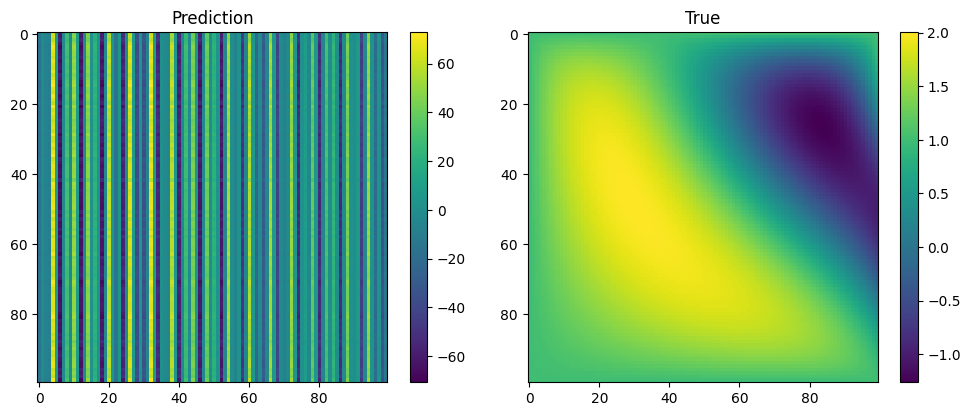

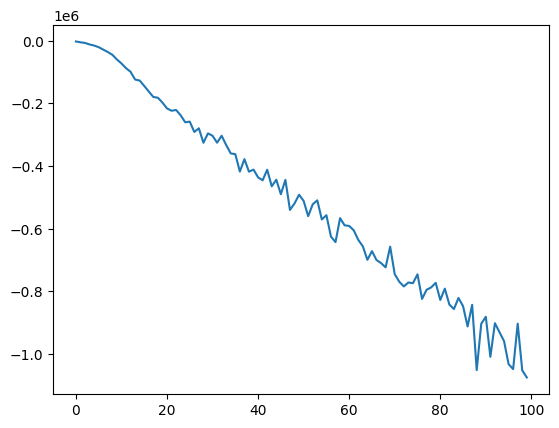

In [46]:
gen.eval()
# print(np.linalg.norm(gen(X[0, 0, :, :]).detach().numpy() - source_term[0, 0, :, :].detach().numpy()))
print(gen(X).shape)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
pred = axs[0].imshow(gen(X).detach().numpy()[:100, :])
axs[0].set_title('Prediction')
plt.colorbar(pred, ax=axs[0])
true = axs[1].imshow(u[0, 0, :, :].detach().numpy())
axs[1].set_title('True')
plt.colorbar(true, ax=axs[1])

plt.tight_layout()
plt.show()

plt.plot(loss_per_epoch)
# print(np.linalg.norm(output - source_term[0, 0, :, :]))